In [1082]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib.pyplot import figure
from pylab import rcParams
from random import randint 
import statistics
import numpy.linalg as la
import math

%matplotlib inline

In [1085]:
df = pd.read_excel('Data Sample (AIC-1).xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
1,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
2,536367,21755,LOVE BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047.0,United Kingdom
3,536368,22914,BLUE COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047.0,United Kingdom
4,536373,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 09:02:00,2.75,17850.0,United Kingdom


Перед тем как начинать анализ, необходимо почистить датасет. <br>
Избавиься от пустых значений ( если их число не превышает критическое значение) <br>
Оценить качество данных

In [1086]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 8 columns):
InvoiceNo      54214 non-null object
StockCode      54214 non-null object
Description    54080 non-null object
Quantity       54214 non-null int64
InvoiceDate    54214 non-null datetime64[ns]
UnitPrice      54214 non-null float64
CustomerID     40643 non-null float64
Country        54214 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 3.3+ MB


In [1087]:
df.isnull().sum()

InvoiceNo          0
StockCode          0
Description      134
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     13571
Country            0
dtype: int64

In [1088]:
neg_Quantity = []

for i in df['Quantity']:
    if i < 0:
        neg_Quantity.append(i)
print(len(neg_Quantity ))

1083


В столбце кол-во около 1083 отрицательных значени. Это может означать: <br>
    > Бронь товара, которого еще нет на складе <br>
    > Воврат товара<br>
    > Брак<br>
    > Битые данные<br>
    > Отсутвие оплаты по товара<br>
Т.к нет возможности выявить причину, уберем их из выборки, чтоб не смазывать даныне ( так делать не очень хорошо, но в условиях невозможности получить фактическую информацию, я себе это позволил)

In [1089]:
neg_price = []

for i in df['UnitPrice']:
    if i < 0:
        neg_price.append(i)
print(len(neg_price))

0


In [1090]:
Share_Description = (df.isnull().sum()['Description']/ len(df.Description))*100
Share_Customer =  (df.isnull().sum()['CustomerID']/ len(df.CustomerID))* 100
Share_Quantity = (len(neg_Quantity ))/ len(df.Quantity)*100
Share_Description= round(Share_Description, 3)
Share_Customer = round(Share_Customer, 3)
Share_Quantity = round(Share_Quantity, 3)

In [1091]:
print(Share_Description,"%", "  - Кол-во пустых значений в описании")
print(Share_Customer,"%", "  - Кол-во пустых значений в столбце покупатель")
print(Share_Quantity,"%", "  -Кол-во отрицательных значений в столбце кол-во")

0.247 %   - Кол-во пустых значений в описании
25.032 %   - Кол-во пустых значений в столбце покупатель
1.998 %   -Кол-во отрицательных значений в столбце кол-во


Видим, что отсутсвуют несколько значение в столбце " Description" 
И около четверти в графе " Customer" <br>
Очистим строки, в которых нет информации о товаре

In [1092]:
df = df.dropna(subset=['Description','InvoiceNo'])

In [1093]:
df = df[df['Quantity'] >= 0]
df.shape

(53081, 8)

Заполним пустые id пользователей случайными, но так чтоб их можно было выделить с общей массы

In [1094]:
len(pd.unique(df['CustomerID']))

3793

Выбираем диапазон, отличающийся от имеющегося в выборке ( нам это потом понадобится для построения дэшборда)

In [1095]:
def fill_missing(column_val):
    if np.isnan(column_val) == True: 
        column_val = np.random.randint(100000, 200000)
    else:
         column_val = column_val
    return column_val

In [1096]:
df['CustomerID'] = df['CustomerID'].apply(fill_missing)

Добавим столбец с итоговой суммой чека ( цена на кол-во) 

In [1097]:
df['Revenue'] = df.Quantity * df.UnitPrice

In [1098]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
1,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08
2,536367,21755,LOVE BUILDING BLOCK WORD,3,2010-12-01 08:34:00,5.95,13047.0,United Kingdom,17.85
3,536368,22914,BLUE COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047.0,United Kingdom,14.85
4,536373,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 09:02:00,2.75,17850.0,United Kingdom,22.00


In [1099]:
len(pd.unique(df['Description']))

3364

Посмотрим основные стат показатели датасета

In [1100]:
df.describe()

,Quantity,UnitPrice,CustomerID,Revenue
count,53081.000000,53081.000000,53081.000000,53081.000000
mean,10.425576,3.831411,49189.528796,19.897289
std,37.627109,17.806366,60225.561764,66.988686
min,1.000000,0.000000,12347.000000,0.000000
25%,1.000000,1.250000,14388.000000,3.900000
50%,3.000000,2.080000,16255.000000,9.900000
75%,11.000000,4.130000,100721.000000,17.700000
max,2400.000000,1687.170000,199999.000000,4121.640000


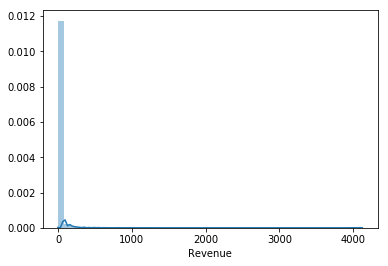

In [1101]:
sns.distplot( df.Revenue)

Из графика видно, что большая доля покупок приходится на малые суммы, <br> 
Посмотрим в приближении

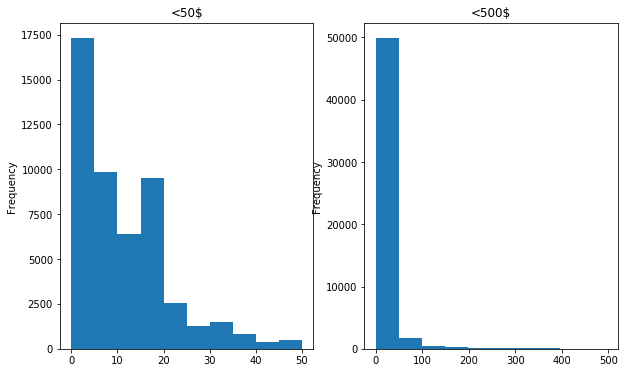

In [1102]:
plt.figure(figsize=(10,6))
plt.subplot(121)
df[df['Revenue'] <= 50].Revenue.plot.hist(title="<50$")
plt.subplot(122)
df[df['Revenue'] <= 500 ].Revenue.plot.hist(title="<500$")

Как видно из графика, большее число заказов приходится на небольшие суммы <br>
Посмотрим детальнее цифры

In [1103]:
rev_bef_50 =df[df['Revenue']<= 50].count()['InvoiceNo']

rev_af_50 = df[df['Revenue']>= 50].count()['InvoiceNo']

print('Кол-во покупок с выручкой до 50$', rev_bef_50)
print('Кол-во покупок с выручкой после 50$', rev_af_50)
print('Доля покупок свыше 50% в общем числе покупок', round(rev_af_50/df.count()['InvoiceNo'],3))

Кол-во покупок с выручкой до 50$ 49996
Кол-во покупок с выручкой после 50$ 3113
Доля покупок свыше 50% в общем числе покупок 0.059


На покупки свыше 50$ приходится меньше 1% от всех покупок <br> следовательно стоит рассматривать "мелкие покупки" как основное направление

Далее оценим средний чек ( ARPPU)

In [1104]:
sum_revenue = df['Revenue'].sum()
num_customers = len(pd.unique(df.CustomerID))

In [1105]:
ARPPU = round((sum_revenue/num_customers),2)
ARPPU

64.8

ARPPU в среднем выше чем средняя выручка с 1 покупки, следовательно клиенты возвращаются и делают повторные покупки <br> Посмотрим


In [1106]:
df_Customer_count = df.groupby('CustomerID').count().sort_values('InvoiceNo', ascending = False)['InvoiceNo']
df_Customer_count.head()

CustomerID
17841.0    759
14096.0    543
14911.0    543
12748.0    446
14606.0    267
Name: InvoiceNo, dtype: int64

Видим какие то аномальные значения, посмотрим в разрезе

In [1107]:
df_big_basket = df_Customer_count[df_Customer_count >= 100]
df_big_basket.count()

19

Покупателей с большим числом покупок всего 19, <br>
Посмотрим какая доля выручки приходится на них

In [1108]:
top_list = df_big_basket.keys().tolist()


In [1109]:
a = df.groupby('CustomerID').sum().reset_index()
top_sum_revenue = a[a['CustomerID'].isin(top_list)].sum()['Revenue']
print(round((top_sum_revenue/df['Revenue'].sum()*100),3),'%', ' Доля выручки клиентов с большим кол-вом повторных покупок в общем числе')

10.032 %  Доля выручки клиентов с большим кол-вом повторных покупок в общем числе


10% от общей выручки проносят всего 19 покупателей, следует выстроить с ними тесное взаимодействие ( если такого еще нет) <br> и проработать персональные предложения для их удержания

Так же есть смысл выделить несколько когорт и проводить анализ в рамках каждой когорты <br>
Например: 
Крупные клиенты - свыше 100 повторных покупок за период ( учитывая что мы рассматриваем период в год есть смысл добавить детализацию в рамках 1 месяца/ недели) <br>
Средние клиенты - от 50 до 100 повторных <br>
Маленькие клиенты - от 20 до 50 повторных за период <br>
Совсем мелкий ( в рамках ABC анализа отнесли бы их к C) - менее 20 за период

In [1110]:
df_small_basket = df_Customer_count[df_Customer_count <= 20]
df_small_basket.count()

15851

In [1111]:
small_list = df_small_basket.keys().tolist()

In [1112]:
a = df.groupby('CustomerID').sum().reset_index()
small_sum_revenue = a[a['CustomerID'].isin(small_list)].sum()['Revenue']
print(round((small_sum_revenue/df['Revenue'].sum()*100),3),'%', ' Доля выручки клиентов с малым кол-вом повторных покупок в общем числе')

58.236 %  Доля выручки клиентов с малым кол-вом повторных покупок в общем числе


Очевидно, что куда целесообразнее разделять клиентов по выручке , но данные по соотношению выручка-число заказов могут дать нам информацию о оптимизации затрат на доставку для данных клиентов ( скидка на опт и.т.д)

Посмотрим сегменитрование по выручке

In [1113]:
df_Reveneu = df.groupby('CustomerID').sum().sort_values('Revenue', ascending = False)['Revenue'].reset_index()
df_Reveneu.head(10)

,CustomerID,Revenue
0,18102.0,26533.44
1,14646.0,25519.16
2,17450.0,23000.10
3,12415.0,16102.89
4,14911.0,15238.45
5,14156.0,12092.71
6,17949.0,12048.08
7,17511.0,9534.21
8,14096.0,8487.80
9,15769.0,8129.04


In [1114]:
big_revenue = df_Reveneu[df_Reveneu['Revenue'] >= 10000]
big_revenue_list = big_revenue['CustomerID'].tolist()
big_revenue_list

[18102.0, 14646.0, 17450.0, 12415.0, 14911.0, 14156.0, 17949.0]

In [1115]:
a = df.groupby('CustomerID').sum().reset_index()
big_sum_revenue = a[a['CustomerID'].isin(big_revenue_list)].sum()['Revenue']
print(round((big_sum_revenue/df['Revenue'].sum()*100),3),'%', ' Доля выручки клиентов с большим объемом выручки')
print(len(big_revenue_list), ' Клиентов делают такую выручку')

12.359 %  Доля выручки клиентов с большим объемом выручки
7  Клиентов делают такую выручку


In [1116]:
small_revenue = df_Reveneu[df_Reveneu['Revenue'] <= 100]
small_revenue_list = small_revenue['CustomerID'].tolist()

In [1117]:
a = df.groupby('CustomerID').sum().reset_index()
small_sum_revenue = a[a['CustomerID'].isin(small_revenue_list)].sum()['Revenue']
print(round((small_sum_revenue/df['Revenue'].sum()*100),3),'%', ' Доля выручки клиентов с большим объемом выручки')
print(len(small_revenue_list), ' Клиентов делают такую выручку')

19.971 %  Доля выручки клиентов с большим объемом выручки
14492  Клиентов делают такую выручку


Анализируя данные о выручке и числе повторных покупок, можно прийти к выводу, что необходимо рассматривать <br>
клиентов в разрезе групп, сегментированных по разному принципу <br>
> Данные о кол-ве повторных - оптимизация доставки <br>

> Данные о выручке - особые условия на опт, удержание клиента и.т.д

In [1118]:
df_InvoiceNo = df.groupby('InvoiceNo').sum()
df_InvoiceNo.head()

,Quantity,UnitPrice,CustomerID,Revenue
InvoiceNo,,,,
536365,6,3.39,17850.0,20.34
536367,35,7.64,26094.0,71.93
536368,3,4.95,13047.0,14.85
536373,8,2.75,17850.0,22.00
536375,6,2.55,17850.0,15.30


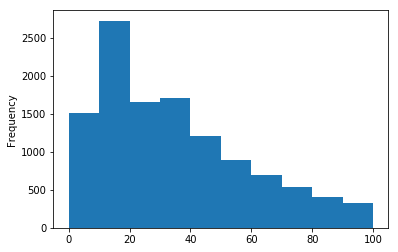

In [1119]:
df_InvoiceNo[df_InvoiceNo['Revenue'] <= 100].Revenue.plot.hist()

Анализируя график, можно прийти к выводу, что чем меньше выручка по заказу - тем больше подобных заказов <br>
Следовательно можно предположить что данные о выручке распределены по экспоненте

In [1120]:
pd.unique(df['Country'])

array(['United Kingdom', 'Australia', 'Netherlands', 'Norway', 'EIRE',
       'France', 'Switzerland', 'Spain', 'Germany', 'Poland', 'Italy',
       'Belgium', 'Lithuania', 'Japan', 'Portugal', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Finland', 'Austria',
       'Sweden', 'Israel', 'Greece', 'Hong Kong', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Czech Republic', 'Canada', 'Unspecified',
       'Brazil', 'USA', 'European Community', 'Bahrain', 'Malta', 'RSA'],
      dtype=object)

Не смотря на то, что это Британская доставка, в датасете присутсвуют и другие страны. <br>
Оценим георграфию бизнеса

In [1121]:
df_country= df.groupby('Country').sum().sort_values('Revenue', ascending = False)['Revenue']
df_country

Country
United Kingdom          892222.871
EIRE                     29008.610
Netherlands              26489.180
Germany                  23706.160
France                   19811.480
Australia                17156.590
Switzerland               6215.900
Spain                     5971.220
Sweden                    4936.520
Belgium                   4066.660
Portugal                  4000.070
Norway                    3859.900
Channel Islands           2877.950
Japan                     2164.180
Denmark                   2058.840
Finland                   2040.600
Italy                     1475.470
Cyprus                    1057.950
Austria                   1036.270
Poland                     911.590
Singapore                  883.080
Hong Kong                  879.010
Israel                     531.720
Unspecified                520.220
Greece                     490.820
Lithuania                  291.600
USA                        290.940
Malta                      287.900
Iceland     

Очевидно, что на Великобританию приходится большая часть выручки, но нам интересно посмотреть другие страны <br>
Уберем Великобританию из списка

In [1122]:
df_country_other = df_country[df_country <= 80000]
df_country_other

Country
EIRE                    29008.61
Netherlands             26489.18
Germany                 23706.16
France                  19811.48
Australia               17156.59
Switzerland              6215.90
Spain                    5971.22
Sweden                   4936.52
Belgium                  4066.66
Portugal                 4000.07
Norway                   3859.90
Channel Islands          2877.95
Japan                    2164.18
Denmark                  2058.84
Finland                  2040.60
Italy                    1475.47
Cyprus                   1057.95
Austria                  1036.27
Poland                    911.59
Singapore                 883.08
Hong Kong                 879.01
Israel                    531.72
Unspecified               520.22
Greece                    490.82
Lithuania                 291.60
USA                       290.94
Malta                     287.90
Iceland                   271.79
Canada                    214.14
United Arab Emirates       96.42
Cz

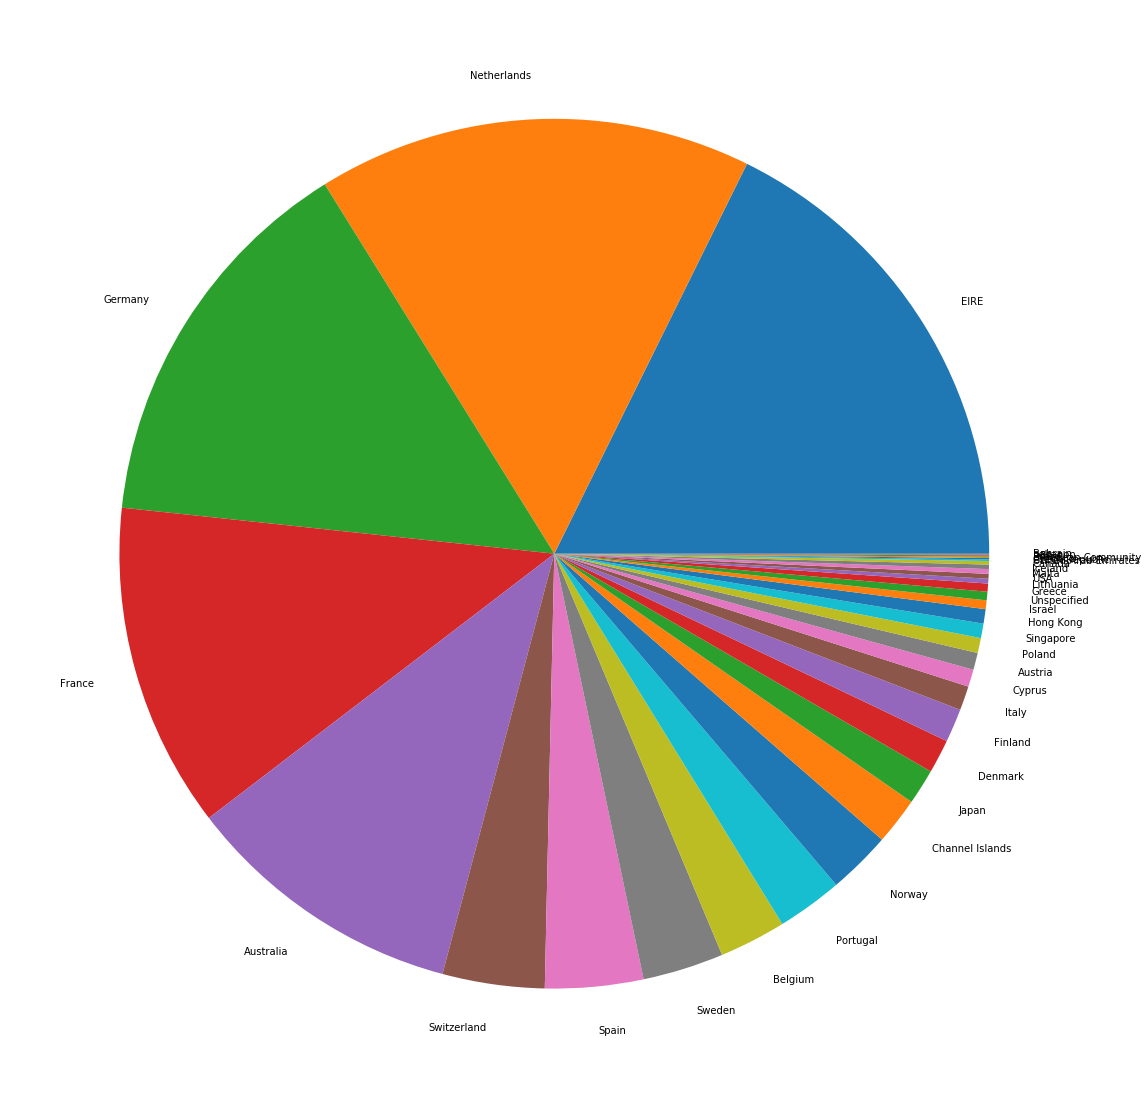

In [1123]:
rcParams['figure.figsize'] = 20, 20
plt.pie(df_country_other,labels = df_country_other.keys())
plt.show()

Оценив топ-5 по выручке, возможно выстроить стратегию по расширению влияния на этих рынках

In [1124]:
df_StockCode = df.groupby('StockCode').sum().sort_values('Revenue', ascending = False)['Revenue']

В датасете присутсвует код акции. Детализации что за этим стоит нет, <br> 
но предположительно это какие то особые условия на товар. Посмотрим какие акции принесли больше всего выручки

In [1125]:
df_StockCode[:20]

StockCode
DOT       20607.25
22423     17135.00
85099B    10092.03
85123A     9609.59
47566      7412.36
POST       7189.16
84879      6975.59
22386      5794.93
22086      5714.65
M          5601.25
79321      5501.53
22470      5393.93
23203      5312.76
82484      5003.81
23173      4998.73
22727      4821.86
22413      4648.72
23344      4621.52
23201      4618.84
23199      4318.38
Name: Revenue, dtype: float64

Откровенно говоря, эти данные слабо релевантны <br> 
Для оценки эффективности акции хорошо бы еще посмотреть затраты. Возможно ни одна из них не выгодна экономически для нас <br>
Возможно цель была не в получении прибыли, а привлечении пользователей. Судить об этом пока что сложно
Но эти данные можно использовать для оценки поведения пользователя и спросе на определенные товары ( либо на условия акции)

In [1126]:
df_InvoiceNo = df.groupby('InvoiceNo').mean()[['Quantity','Revenue']].sort_values('Revenue', ascending = False)
df_InvoiceNo.head()

,Quantity,Revenue
InvoiceNo,,
540689,1284.0,4121.64
581115,1404.0,3861.00
556725,200.0,2496.00
574294,2100.0,2226.00
554366,888.0,2131.20


In [1127]:
print(round((df[df['CustomerID']>100000].sum()['Revenue']/df['Revenue'].sum())*100,3),'%', '- Доля выручки клиентов, по которым нет данных')

16.463 % - Доля выручки клиентов, по которым нет данных


Опираясь на эти данные, можно прийти к выводу, что немногим больше 16% выручки нам приносят "неизвестно кто" <br>
Получив данные по клиентам, мы могли бы детальней проанализировать их потребности и вывести на повторную покупку

Далее, на основании этих данных построим дэшборд с ключевыми метриками

In [1130]:
df.to_excel("DF.xlsx") 